# Step Current Moments Based Summary Statiscits Development

In [46]:
import timeit
import numpy as np
import matplotlib.pyplot as plt

from dap import DAPcython
from dap.dap_sumstats_moments import DAPSummaryStatsMoments

from dap.utils import obs_params_gbar, syn_current
from dap.cell_fitting.read_heka import (get_sweep_index_for_amp, get_i_inj_from_function,
                                        get_v_and_t_from_heka, shift_v_rest, get_i_inj_zap)
from scipy import stats as spstats

In [2]:
from dap.dap_sumstats_moments import DAPSummaryStatsMoments

## Simulate both protocols

In [3]:
def load_current(data_dir, protocol='rampIV', ramp_amp=3.1):
    '''
    ramp_amp:  optimal=3.1, steps of 0.05 -0.15
    protocol: 'rampIV', 'IV', 'Zap20'

    '''
    v_shift = -16  # shift for accounting for the liquid junction potential

    if protocol == 'Zap20':
        sweep_idx = 0
    else:
        sweep_idx = get_sweep_index_for_amp(ramp_amp, protocol)

    v, t = get_v_and_t_from_heka(data_dir, protocol, sweep_idxs=[sweep_idx])
    v = shift_v_rest(v[0], v_shift)
    t = t[0]
    dt = t[1] - t[0]

    I, t_on, t_off = get_i_inj_from_function(protocol, [sweep_idx], t[-1], dt,
                                              return_discontinuities=False)

    I = I[0]

    return I, v, t, t_on, t_off, dt

In [4]:
dt = 1e-2
params, labels = obs_params_gbar()
data_dir = '/home/ateska/Desktop/LFI_DAP/data/rawData/2015_08_26b.dat'    # best cell
# data_dir = '/home/ateska/Desktop/LFI_DAP/data/rawData/2015_08_11d.dat'  # second best cell

In [5]:
# load the data
I, v, t, t_on, t_off, dt = load_current(data_dir, protocol='rampIV', ramp_amp=3.1)
I_iv, v_iv, t_iv, t_on_iv, t_off_iv, dt_iv = load_current(data_dir, protocol='IV', ramp_amp=1)

In [6]:
# define and run the model
dap = DAPcython(-75, params)
U = dap.simulate(dt, t, I)
U_iv = dap.simulate(dt_iv, t_iv, I_iv)

## Comparison to sumstats for RAMP

In [7]:
x_1 = {'data': U.reshape(-1),
       'time': t,
       'dt': t[1]-t[0],
       'I': I[0]}


# calcualte summary statistics
sum_stats_mom = DAPSummaryStatsMoments(t_on, t_off, n_summary=17)
print('moments summary stats synt:', sum_stats_mom.calc([x_1]))

spikes!!!: 1
moments summary stats synt: [[-7.51157804e+01  7.40128482e-02 -7.32932387e+01  1.00000000e+00
   5.49890166e-01  2.96840307e-01  2.82139352e-01  2.86233102e-01
   1.53620138e+03  7.65625622e-01  2.47555795e+00  3.89730573e+00
   3.06789265e+01  1.17714257e+00  3.94089356e+00  1.35035568e+01
   1.00000000e+00]]


## Compute the new sumstats

In [8]:
print("cython:", timeit.timeit(lambda: dap.simulate(dt, t, I), number=int(1)))
print("cython:", timeit.timeit(lambda: dap.simulate(dt_iv, t_iv, I_iv), number=int(1)))

print(dt, dt_iv)

cython: 0.5113862540165428
cython: 0.6786130010150373
0.01 0.05


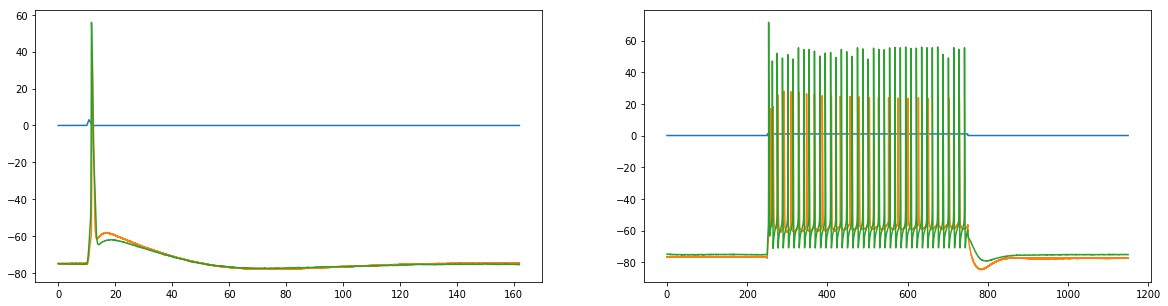

In [9]:

fig, ax = plt.subplots(1, 2, figsize=(20,5))
ax[0].plot(t, I)
ax[0].plot(t, v)
ax[0].plot(t, U)
ax[1].plot(t_iv, I_iv)
ax[1].plot(t_iv, v_iv)
ax[1].plot(t_iv, U_iv);

## Summary Statistics for Step Current

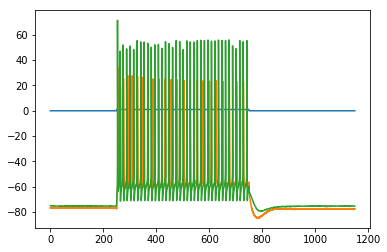

In [10]:
plt.plot(t_iv, I_iv)
plt.plot(t_iv, v_iv)
plt.plot(t_iv, U_iv);

In [11]:
data = U_iv
t = t_iv
t

array([0.00000e+00, 5.00000e-02, 1.00000e-01, ..., 1.14985e+03,
       1.14990e+03, 1.14995e+03])

In [12]:
x = {'data': data.reshape(-1)}
x

{'data': array([-74.99471973, -75.0036103 , -74.98227348, ..., -75.20546092,
        -75.20005144, -75.21861805])}

In [13]:
N = data.shape[0]
dt = t[1] - t[0]
t_on = t_on_iv
t_off = t_off_iv

n_mom = 5
n_xcorr = 4

ind (array([    0,     1,     2, ..., 22997, 22998, 22999]), array([0, 0, 0, ..., 0, 0, 0]))


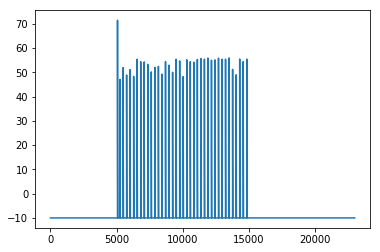

In [14]:
v = np.copy(data)

# put everything to -10 that is below -10 or has negative slope
ind = np.where(v < -10)
print('ind', ind)

v[ind] = -10
plt.plot(v);

In [15]:
np.diff(data)

array([], shape=(23000, 0), dtype=float64)

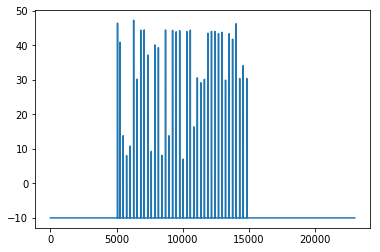

In [16]:
ind2 = np.where(np.diff(v, axis=0) < 0)
# print('ind2', ind2);

v[ind2] = -10
plt.plot(v);

In [17]:
t_on = t_on_iv

### Spike Times

In [18]:
spike_times = np.array(t)[ind2[0]]
spike_times;

In [19]:
spike_times_stim = spike_times[(spike_times > t_on) & (spike_times < t_off)]
spike_times_stim;

In [20]:
# plt.scatter(ind2[0], np.zeros_like(spike_times_stim))

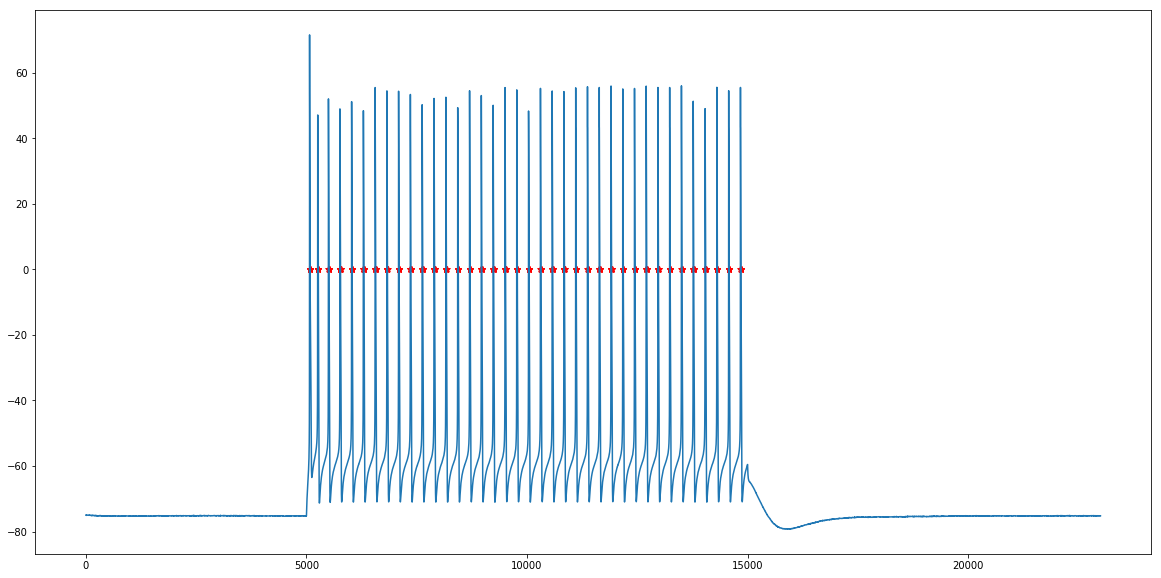

In [21]:
plt.figure(figsize=(20,10))
plt.scatter(ind2[0], np.zeros_like(spike_times_stim), c='red', marker='*');
plt.plot(U_iv);
# plt.plot(v_iv);

In [22]:
# number of spikes
if spike_times_stim.shape[0] > 0:
    spike_times_stim = spike_times_stim[np.append(1, np.diff(spike_times_stim))>0.5]

In [23]:
len(spike_times_stim)

38

In [52]:
spike_times_stim

array([253.5 , 262.75, 274.9 , 287.9 , 301.15, 314.5 , 327.85, 341.15,
       354.4 , 367.75, 381.1 , 394.6 , 408.  , 421.4 , 434.85, 448.15,
       461.6 , 475.05, 488.35, 501.7 , 515.2 , 528.5 , 541.8 , 555.15,
       568.5 , 581.85, 595.2 , 608.5 , 621.8 , 635.05, 648.35, 661.65,
       675.  , 688.35, 701.8 , 715.15, 728.55, 741.9 ])

### Inter spike interval 

In [24]:
# ISI
ISI = np.diff(spike_times_stim).astype(float)
ind = [0,1,-1]
ISI1 = np.array([1000.]*3)
ISI1[0:np.maximum(0,spike_times_stim.shape[0]-1)] = ISI[ind[0:np.maximum(0,spike_times_stim.shape[0]-1)]]

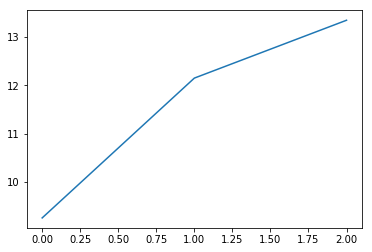

In [25]:
plt.plot(ISI1);

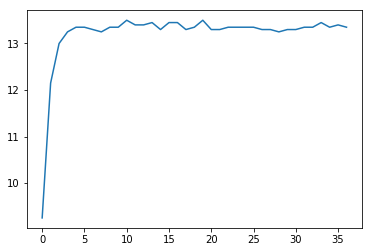

In [26]:
plt.plot(ISI);

In [27]:
ISI

array([ 9.25, 12.15, 13.  , 13.25, 13.35, 13.35, 13.3 , 13.25, 13.35,
       13.35, 13.5 , 13.4 , 13.4 , 13.45, 13.3 , 13.45, 13.45, 13.3 ,
       13.35, 13.5 , 13.3 , 13.3 , 13.35, 13.35, 13.35, 13.35, 13.3 ,
       13.3 , 13.25, 13.3 , 13.3 , 13.35, 13.35, 13.45, 13.35, 13.4 ,
       13.35])

In [49]:
if spike_times_stim.shape[0] > 1:
    ISImom = np.array([np.mean(ISI),np.std(ISI)])
else:
    ISImom = np.array([t_off,0.])

ISImom

a


array([13.2       ,  0.69135589])

In [48]:
ISI1 = np.array([t_off-t_on,0.])
print(ISI1)
ISI1[0:np.maximum(0,spike_times_stim.shape[0]-1)] = ISImom[0:np.maximum(0,spike_times_stim.shape[0]-1)]

[500.   0.]


In [30]:
ISI1

array([13.2       ,  0.69135589])

In [31]:
# accommodation index
if spike_times_stim.shape[0] < 3:
   A_ind = 1000
else:
   ISI = np.diff(spike_times_stim)
   A_ind = np.mean( [ (ISI[i_min+1]-ISI[i_min])/(ISI[i_min+1]+ISI[i_min]) for i_min in range (0,ISI.shape[0]-1)] )

In [32]:
A_ind

0.005072070049250216

In [33]:
# resting potential and std
rest_pot = np.mean(x['data'][t<t_on])
rest_pot_std = np.std(x['data'][int(.9*t_on/dt):int(t_on/dt)])

In [34]:
# auto-correlations
x_on_off = x['data'][(t > t_on) & (t < t_off)]-np.mean(x['data'][(t > t_on) & (t < t_off)])
x_on_off

array([-20.62682857, -20.18503231, -19.73351431, ...,  -5.975187  ,
        -5.93737658,  -5.9205338 ])

In [51]:
x_corr_val = np.dot(x_on_off,x_on_off)
x_corr_val

4661387.096306527

In [36]:
xcorr_steps = np.linspace(1./dt,n_xcorr*1./dt,n_xcorr).astype(int)
xcorr_steps

array([20, 40, 60, 80])

In [37]:
x_corr_full = np.zeros(n_xcorr)
x_corr_full

array([0., 0., 0., 0.])

In [38]:
# auto-correlations
x_on_off = x['data'][(t > t_on) & (t < t_off)]-np.mean(x['data'][(t > t_on) & (t < t_off)])
x_corr_val = np.dot(x_on_off,x_on_off.transpose())

xcorr_steps = np.linspace(1./dt, n_xcorr*1./dt, n_xcorr).astype(int)
x_corr_full = np.zeros(n_xcorr)

In [39]:
for ii in range(n_xcorr):
    x_on_off_part = np.concatenate((x_on_off[xcorr_steps[ii]:], np.zeros(xcorr_steps[ii])))  
    x_corr_full[ii] = np.dot(x_on_off,x_on_off_part)

x_corr1 = x_corr_full/x_corr_val

In [42]:
std_pw = np.power(np.std(x['data'][(t > t_on) & (t < t_off)]), np.linspace(3,n_mom,n_mom-2))
std_pw = np.concatenate((np.ones(1),std_pw))
moments = spstats.moment(x['data'][(t > t_on) & (t < t_off)], np.linspace(2,n_mom,n_mom-1))/std_pw


In [43]:
sum_stats_vec = np.concatenate((
        np.array([rest_pot,rest_pot_std,np.mean(x['data'][(t > t_on) & (t < t_off)]), spikes]),    
        np.array([spike_times_stim.shape[0]]),
        x_corr1,
        moments,
        ISI1,
    ))

In [44]:
sum_stats_vec

array([ 3.80000000e+01,  2.26940358e-01, -1.48410902e-01, -1.42418114e-01,
       -1.26340311e-01, -7.52052777e+01,  2.91779183e-02, -5.36240907e+01,
        4.66185328e+02,  2.98256089e+00,  1.19181184e+01,  4.87832529e+01])

In [45]:
print('moments summary stats synt:', sum_stats_mom.calc([x_1]))

spikes!!!: 1
moments summary stats synt: [[-7.51157804e+01  7.40128482e-02 -7.32932387e+01  1.00000000e+00
   5.49890166e-01  2.96840307e-01  2.82139352e-01  2.86233102e-01
   1.53620138e+03  7.65625622e-01  2.47555795e+00  3.89730573e+00
   3.06789265e+01  1.17714257e+00  3.94089356e+00  1.35035568e+01
   1.00000000e+00]]
